# Spaceship Titanic

## Overview

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, 
the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets 
orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic
collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000
years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the 
Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal
records recovered from the ship's damaged computer system.

## File and Data Field Descriptions

### train.csv 

Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

Sure! Here's the code converted to a markdown table:

| Column Name | Description |
|------------- |-------------|
| `PassengerId` | A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always. |
| `HomePlanet` | The planet the passenger departed from, typically their planet of permanent residence. |
| `CryoSleep` | Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins. |
| `Cabin` | The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard. |
| `Destination` | The planet the passenger will be debarking to. |
| `Age` | The age of the passenger. |
| `VIP` | Whether the passenger has paid for special VIP service during the voyage. |
| `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` | Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities. |
| `Name` | The first and last names of the passenger. |
| `Transported` | Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict. |

### test.csv

Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. 

Your task is to predict the value of Transported for the passengers in this set.
    
### sample_submission.csv

A sample submission file in the correct format.

| Column Name | Description |
|------------- |-------------|
| `PassengerId` | A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always. |
| `Transported` | Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict. |

In [455]:
# Library imports

# Data wrangling
import pandas as pd
import numpy as np
import missingno
from collections import Counter

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine learning models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# Model evaluation
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Data preprocessing

## Drop unrequired features & add engineered ones

In [456]:
# Load the data - to pandas dataframes

test_df = pd.read_csv('./inputs/test.csv')
test_idx = test_df['PassengerId']
train_df = pd.read_csv('./inputs/train.csv')

In [457]:
# split name into components
def split_name(name:str):
    if pd.isnull(name): # protect against empty values
        return (np.nan, np.nan, np.nan)
    parts = name.split(' ')
    first = parts[0]
    last = parts[-1]
    return (first, last)

# split cabin into components
def split_cabin(name:str):
    if pd.isnull(name): # protect against empty values
        return (np.nan, np.nan, np.nan)
    parts = name.split('/')
    deck = parts[0]
    side = parts[-1]
    number = ' '.join(parts[1:-1])
    return (deck, number, side)

# This function will drop and add required features
def feature_manipulation(d : pd.DataFrame) -> pd.DataFrame:
    # print the shape of the provided dataframe
    print("Before: ", d.shape)
    # Clone the provided dataframe
    df = d.copy()

    _, df['Name'] = zip(*df['Name'].map(split_name))
    
    # Location
    df['Deck'], _, df['Side'] = zip(*df['Cabin'].map(split_cabin))
    df['DeckSide'] = df['Deck'] + df['Side'] # Combine Deck and Side
    df.drop(['Deck', 'Side'], axis = 1, inplace = True) # Drop temporary cols

    # Group related columns
    df['Group'] = df['PassengerId'].map(lambda x: x.split('_')[0])
    df['GroupSize'] = df['Group'].map(df['Group'].value_counts())
    
    # Need to do it this way to treat NaN as 0 otherwise any NaN will make the total NaN
    df['TotalSpend'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0).sum(axis=1) 
    
    print("After: ", df.shape)
    return df

In [458]:
train_df = feature_manipulation(train_df)

Before:  (8693, 14)
After:  (8693, 18)


In [459]:
test_df = feature_manipulation(test_df)

Before:  (4277, 13)
After:  (4277, 17)


In [460]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,DeckSide,Group,GroupSize,TotalSpend
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Ofracculy,False,BP,0001,1,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Vines,True,FS,0002,1,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Susent,False,AS,0003,2,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Susent,False,AS,0003,2,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Santantines,True,FS,0004,1,1091.0


In [461]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,DeckSide,Group,GroupSize,TotalSpend
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Carsoning,GS,0013,1,0.0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Peckers,FS,0018,1,2832.0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Unhearfus,CS,0019,1,0.0
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Caltilter,CS,0021,1,7418.0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Harperez,FS,0023,1,645.0


## Handle Missing Data

As we saw earlier and below there is a consistent background level of missing data < 3% for a given column

In [462]:
print(f'Before: {len(train_df)} rows')
train_df.isnull().sum().sort_values(ascending = False)

Before: 8693 rows


CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
DeckSide        199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Group             0
GroupSize         0
PassengerId       0
Transported       0
TotalSpend        0
dtype: int64

In [463]:
print(f'Before: {len(test_df)} rows')
train_df.isnull().sum().sort_values(ascending = False)

Before: 4277 rows


CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
DeckSide        199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Group             0
GroupSize         0
PassengerId       0
Transported       0
TotalSpend        0
dtype: int64

In [464]:
# rows with no missing values

print(f'Before: {len(train_df)} rows')
train_nona = train_df.dropna()
print(f'After: {len(train_nona)} rows')

Before: 8693 rows
After: 6606 rows


Though we could probably afford to drop 25% of the data it is a lot to lose and also will be tricky to handly when predicting the test set as we cannot drop that.

### Missing Data: Boolean features

VIP and CryoSleep are both booleans and so picking one or other for these is unlikely to help the model they also seem to be predictive so will drop the rows where those are missing

#### VIP

Potential assumptions:

1. You are not a VIP i.e. modal imputation
2. If you spend a lot of money you are a VIP?
3. If somebody else in your group is a VIP is then you are? you are if you share a last name?
4. If you spend money on certain things are you a VIP?

In [465]:
# TEST Assumption 1 - all VIP

count_vips = train_df['VIP'].sum()
total = len(train_df)
count_not_vips = (train_df['VIP'] == False).sum()
count_nan_vips = train_df['VIP'].isnull().sum()
print(f'VIPs      count: {count_vips} ({count_vips/total:.2%})')
print(f'Not VIPs  count: {count_not_vips} ({count_not_vips/total:.2%})')
print(f'Nan VIPs  count: {count_nan_vips} ({count_nan_vips/total:.2%})')
print(f'Total: {total}')

# print the rows where VIP is NaN or null
train_df[train_df['VIP'].isnull()].head()

print(f'{count_vips + count_not_vips + count_nan_vips} == {total}')

print(f'Percentage of cases where VIP status set where just saying False would be incorrect: {count_vips/(total-count_nan_vips):.2%}')


VIPs      count: 199 (2.29%)
Not VIPs  count: 8291 (95.38%)
Nan VIPs  count: 203 (2.34%)
Total: 8693
8693 == 8693
Percentage of cases where VIP status set where just saying False would be incorrect: 2.34%


So **2.34%** is the number to beat!

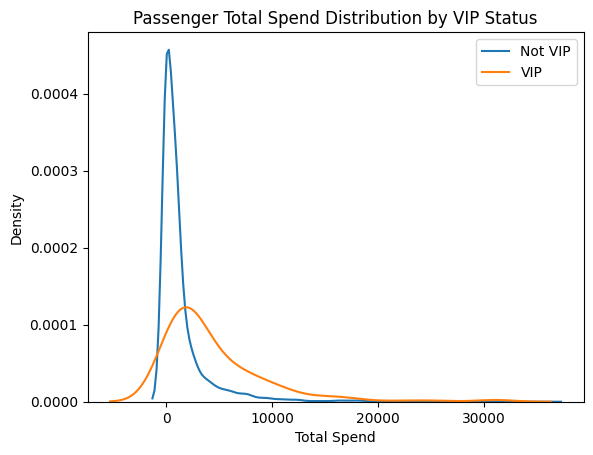

In [466]:
# TEST Assumption 2 - plot TotalSpend by VIP

sns.kdeplot(train_df['TotalSpend'][train_df['VIP'] == False], label = 'Not VIP')
sns.kdeplot(train_df['TotalSpend'][train_df['VIP'] == True], label = 'VIP')
plt.xlabel('Total Spend')
plt.title('Passenger Total Spend Distribution by VIP Status')
plt.legend()

In [467]:
# a) how many non-VIP have a total spend of greater than or VIPs with spend == zero
print(f'a) VIPs with TotalSpend == 0: {len(train_df[(train_df["VIP"] == True) & (train_df["TotalSpend"] == 0)])}')
print(f'a) Non-VIPs with TotalSpend > 0: {len(train_df[(train_df["VIP"] == False) & (train_df["TotalSpend"] > 0)])}')

# b) VIP status of null with TotalSpend set
print(f'b) VIP status unknown with TotalSpend > 0: {len(train_df[(train_df["VIP"].isnull()) & (train_df["TotalSpend"] > 0)])}')
condition = (train_df["VIP"].isnull()) & (train_df["TotalSpend"] > 0) & train_df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].notnull().any(axis=1)
any_non_null_spend_count = len(train_df[condition])
print(f'b) VIP status unknown and one of RoomService, FoodCourt, ShoppingMall, Spa, VRDeck is not null/nan: {any_non_null_spend_count}')


a) VIPs with TotalSpend == 0: 28
a) Non-VIPs with TotalSpend > 0: 4759
b) VIP status unknown with TotalSpend > 0: 110
b) VIP status unknown and one of RoomService, FoodCourt, ShoppingMall, Spa, VRDeck is not null/nan: 110


In [468]:
# c) Given a) returns many rows lets try to set some threshold values and compare VIPs and non-VIPs to set a good threshold
thresholds = [0, 100, 500, 1000, 2500, 5000, 10000, 20000, 30000, 40000]

def create_threshold_df(df: pd.DataFrame, thresholds: list) -> pd.DataFrame:
    VIP = (df["VIP"] == True)
    NotVIP = (df["VIP"] == False)
    UnsetVIP = (df["VIP"].isnull() | df["VIP"].isna())
    thresholds_df = pd.DataFrame(data=thresholds, columns = ['Threshold'])
    count_VIP = len(df[df["VIP"] == True])
    count_nonVIP = len(df[df["VIP"] == False])
    count_nanVIP = len(df[df["VIP"].isnull() | df["VIP"].isna()])

    # Firstly we need a column with the count of VIPs with TotalSpend > Threshold
    thresholds_df['VIPs GT'] = thresholds_df['Threshold'].map(lambda x: len(df[VIP & (df["TotalSpend"] > x)]))
    # Percentage of the VIPs with TotalSpend > Threshold
    thresholds_df['VIPs GT %'] = thresholds_df['VIPs GT'].map(lambda x: (x/count_VIP) * 100)
    # Count of non-VIPs with TotalSpend > Threshold
    thresholds_df['NonVIPs GT'] = thresholds_df['Threshold'].map(lambda x: len(df[NotVIP & (df["TotalSpend"] > x)]))
    # Percentage of the non-VIPs with TotalSpend > Threshold
    thresholds_df['NonVIPs GT %'] = thresholds_df['NonVIPs GT'].map(lambda x: (x/count_nonVIP) * 100)
    # Count of NaN VIPs with TotalSpend > Threshold
    thresholds_df['NanVIPs GT'] = thresholds_df['Threshold'].map(lambda x: len(df[UnsetVIP & (df["TotalSpend"] > x)]))
    # Percentage of the NaN VIPs with TotalSpend > Threshold
    thresholds_df['NanVIPs GT %'] = thresholds_df['NanVIPs GT'].map(lambda x: (x/count_nanVIP) * 100)

    # Repeat the above but this time looking for below the threshold
    thresholds_df['VIPs LT'] = thresholds_df['Threshold'].map(lambda x: len(df[VIP & (df["TotalSpend"] < x)]))
    thresholds_df['VIPs LT %'] = thresholds_df['VIPs LT'].map(lambda x: (x/count_VIP) * 100)
    thresholds_df['NonVIPs LT'] = thresholds_df['Threshold'].map(lambda x: len(df[NotVIP & (df["TotalSpend"] < x)]))
    thresholds_df['NonVIPs LT %'] = thresholds_df['NonVIPs LT'].map(lambda x: (x/count_nonVIP) * 100)
    thresholds_df['NanVIPs LT'] = thresholds_df['Threshold'].map(lambda x: len(df[UnsetVIP & (df["TotalSpend"] < x)]))
    thresholds_df['NanVIPs LT %'] = thresholds_df['NanVIPs LT'].map(lambda x: (x/count_nanVIP) * 100)

    return thresholds_df


create_threshold_df(train_df, thresholds)


,Threshold,VIPs GT,VIPs GT %,NonVIPs GT,NonVIPs GT %,NanVIPs GT,NanVIPs GT %,VIPs LT,VIPs LT %,NonVIPs LT,NonVIPs LT %,NanVIPs LT,NanVIPs LT %
0,0,171,85.929648,4759,57.399590,110,54.187192,0,0.000000,0,0.000000,0,0.000000
1,100,170,85.427136,4728,57.025691,110,54.187192,29,14.572864,3563,42.974309,93,45.812808
2,500,170,85.427136,4655,56.145218,110,54.187192,29,14.572864,3635,43.842721,93,45.812808
3,1000,161,80.904523,2612,31.504041,60,29.556650,38,19.095477,5679,68.495959,143,70.443350
4,2500,107,53.768844,1220,14.714751,23,11.330049,92,46.231156,7071,85.285249,180,88.669951
5,5000,60,30.150754,564,6.802557,13,6.403941,139,69.849246,7727,93.197443,190,93.596059
6,10000,21,10.552764,153,1.845375,7,3.448276,178,89.447236,8138,98.154625,196,96.551724
7,20000,4,2.010050,27,0.325654,0,0.000000,195,97.989950,8264,99.674346,203,100.000000
8,30000,2,1.005025,2,0.024123,0,0.000000,197,98.994975,8289,99.975877,203,100.000000
9,40000,0,0.000000,0,0.000000,0,0.000000,199,100.000000,8291,100.000000,203,100.000000


In [469]:
# OK given all this data lets try to beat the baseline 2.34% wrong
# If we use spend to determine VIP status lets see what result that would give

data = []
for t in thresholds:
    condition = (train_df["TotalSpend"] > t)
    count = len(train_df[condition])
    vip_count = len(train_df[condition & train_df["VIP"]])
    not_vip_count = len(train_df[condition & (train_df["VIP"] == False)])
    error_calc = count - vip_count
    data.append([t, count, vip_count, not_vip_count, error_calc])

pd.DataFrame(data, columns=['Threshold', 'Total Rows above t', 'Actually VIP Rows', 'Not VIP', 'FP'])

,Threshold,Total Rows above t,Actually VIP Rows,Not VIP,FP
0,0,5040,171,4759,4869
1,100,5008,170,4728,4838
2,500,4935,170,4655,4765
3,1000,2833,161,2612,2672
4,2500,1350,107,1220,1243
5,5000,637,60,564,577
6,10000,181,21,153,160
7,20000,31,4,27,27
8,30000,4,2,2,2
9,40000,0,0,0,0


Conclusions from this comparison of TotalSpend

* Nobody spent more than 40000
* Not a totally clear threshold above this VIP below this non-VIP 
  * 2 of each for example between 30k and 40k
  * 29 VIPs spent less than 100
* skew in numbers i.e. many more non-VIP than VIP does not help 
* From the percentages

**Conclusion** there is way too much overlap to use just `TotalSpend` even if we took 30k (which is the best performing) we would have 50% error!

In [470]:
# TEST Assumption 3 - if somebody else in your group is a VIP is then you are?

# get counts of people in groups with VIPs and counts of VIPs in those groups
# convert to a dataframe with the columns Group, GroupSize, VIPsInGroup, TotalInGroup 
# only keep groups with a VIP in them

# create a dataframe with Group and VIP columns

group_vips = train_df[['Group', 'VIP', 'GroupSize']]
group_vips['VIPI'] = group_vips['VIP'].map(lambda x: 1 if x == True else 0)

# Count the VIPs in the group
group_vips['GroupVIPCount'] = group_vips.groupby('Group')['VIPI'].transform('sum') 

# group the data summing VIPI and keeping columns Group and GroupSize
group_vips = group_vips.groupby('Group').agg({'GroupSize': 'first', 'VIPI': 'sum'}).reset_index()

group_vips['NVIPI'] = group_vips['GroupSize'] - group_vips['VIPI']

# drop the data with no VIPs in the group
group_vips = group_vips[group_vips['VIPI'] > 0]

# Extra VIPs in the group
group_vips['ExtraVIPs'] = group_vips['GroupSize'] - 1 - group_vips['NVIPI']

# group the data by group size
group_vips = group_vips.groupby('GroupSize').agg({'ExtraVIPs': 'sum', 'NVIPI': 'sum'}).reset_index()

group_vips



,GroupSize,ExtraVIPs,NVIPI
0,1,0,0
1,2,1,57
2,3,2,42
3,4,1,41
4,5,1,19
5,6,0,30
6,7,0,6


This suggests extra VIPs are rare enough this is unlikely to succeed

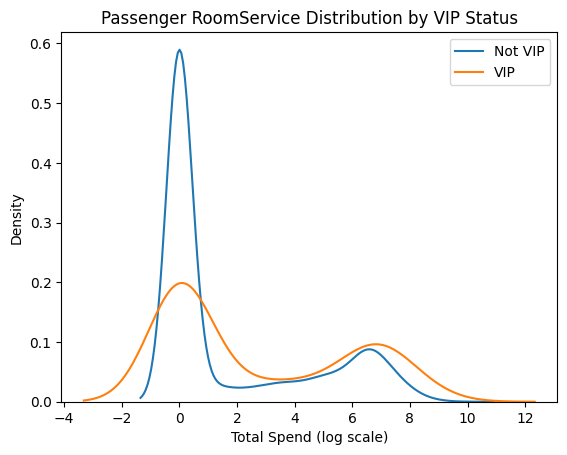

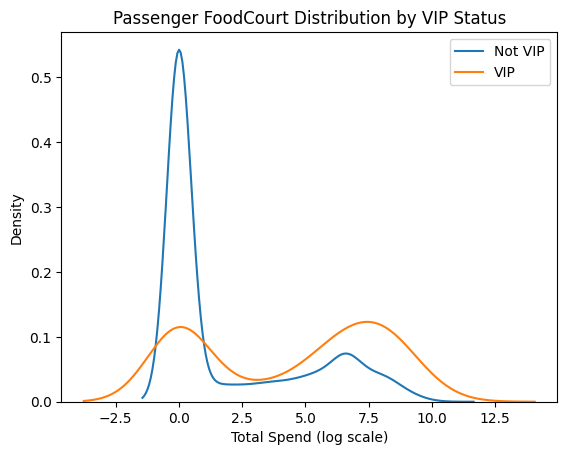

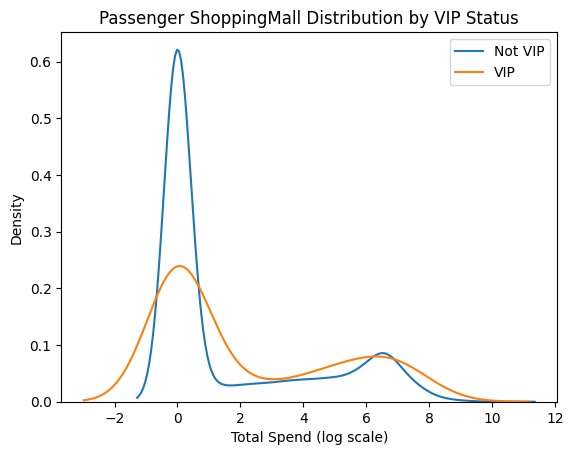

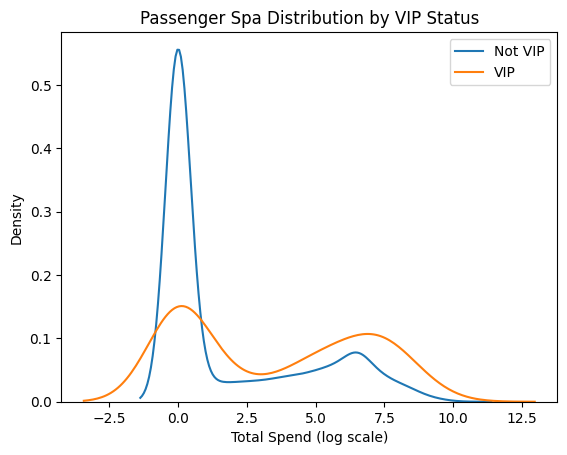

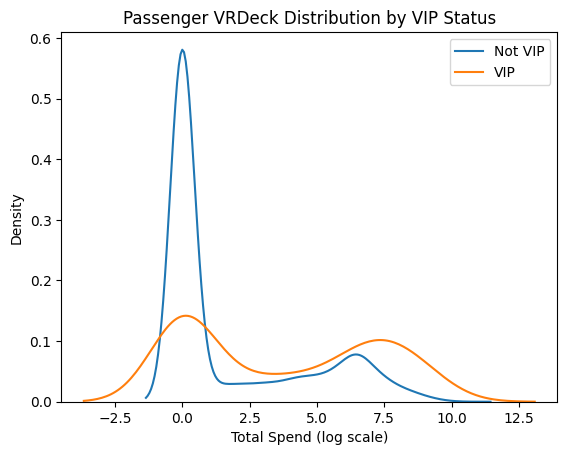

In [471]:
# TEST Assumption 4 - If you spend money on certain things are you a VIP?

# for this we need to plot the spend on each of the spending features against VIP status


# for category in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
#     sns.kdeplot(train_df[category][train_df['VIP'] == False], label = 'Not VIP')
#     sns.kdeplot(train_df[category][train_df['VIP'] == True], label = 'VIP')
#     plt.xlabel('Total Spend')
#     plt.title(f'Passenger {category} Distribution by VIP Status')
#     plt.legend()
#     plt.show()

# The above was hard to interpret due to the large spread and big peak at zwero

for category in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    # Add a small constant to avoid taking the log of zero
    non_vip_data = np.log1p(train_df[category][train_df['VIP'] == False])
    vip_data = np.log1p(train_df[category][train_df['VIP'] == True])

    sns.kdeplot(non_vip_data, label = 'Not VIP')
    sns.kdeplot(vip_data, label = 'VIP')
    plt.xlabel('Total Spend (log scale)')
    plt.title(f'Passenger {category} Distribution by VIP Status')
    plt.legend()
    plt.show()

The graphs show that they are fairly alike albeit with a much bigger peak at zero for non-VIPs

#### VIP Conclusions

- we should set nan/null to False in the VIP column as VIPs are rare

#### CryoSleep

Some potential ways to set this correctly

1. Assume that if you spend any money then you are not asleep!
2. Assume that if most of your group are asleep then you are

In [472]:
count_cryos = train_df['CryoSleep'].sum()
total = len(train_df)
count_not_cryos = (train_df['CryoSleep'] == False).sum()
count_nan_cryos = train_df['CryoSleep'].isnull().sum()
print(f'cryos      count: {count_cryos} ({count_cryos/total:.2%})')
print(f'Not cryos  count: {count_not_cryos} ({count_not_cryos/total:.2%})')
print(f'Nan cryos  count: {count_nan_cryos} ({count_nan_cryos/total:.2%})')
print(f'Total: {total}')


cryos      count: 3037 (34.94%)
Not cryos  count: 5439 (62.57%)
Nan cryos  count: 217 (2.50%)
Total: 8693


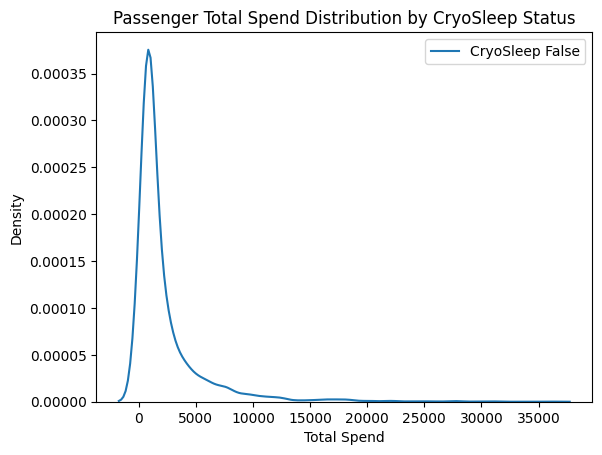

In [473]:
# Plot TotalSpend for CryoSleep True vs False
sns.kdeplot(train_df['TotalSpend'][train_df['CryoSleep'] == False], label = 'CryoSleep False')
sns.kdeplot(train_df['TotalSpend'][train_df['CryoSleep'] == True], label = 'CryoSleep True')
plt.xlabel('Total Spend')
plt.title('Passenger Total Spend Distribution by CryoSleep Status')
plt.legend()


In [474]:
print(f'Total CryoSleep True: {len(train_df[train_df["CryoSleep"] == True])}')
print(f'Total CryoSleep False: {len(train_df[train_df["CryoSleep"] == False])}')

Total CryoSleep True: 3037
Total CryoSleep False: 5439


In [475]:
# How many spent > 0 where CryoSleep is null/nan?

UnsetCryo = (train_df["CryoSleep"].isnull() | train_df["CryoSleep"].isna())
Awake = (train_df["CryoSleep"] == False)
print(f'Unset CryoSleep with TotalSpend > 0: {len(train_df[(UnsetCryo) & (train_df["TotalSpend"] > 0)])}')
print(f'Unset CryoSleep with TotalSpend == 0: {len(train_df[(UnsetCryo) & (train_df["TotalSpend"] == 0)])}')
print(f'Sum total spent by those with CryoSleep = True: {train_df["TotalSpend"][train_df["CryoSleep"] == True].sum()}')
print(f'Awake with TotalSpend > 0: {len(train_df[(Awake) & (train_df["TotalSpend"] > 0)])}')

# Spend == 0 in CryoSleep!

Unset CryoSleep with TotalSpend > 0: 119
Unset CryoSleep with TotalSpend == 0: 98
Sum total spent by those with CryoSleep = True: 0.0
Awake with TotalSpend > 0: 4921


In [476]:
# Does your group affect whether you are in CryoSleep?

# This is the data I need to create
# | CryoSleep_True | CryoSleep_False | CryoSleep_Unset | Number of Groups  |
# |----------------|-----------------|-----------------|-------------------|
# |     Yes        |     Yes         |       No        |         3         |

cryo_dict = []

# for group in train_df['Group'].unique():
#     cryo = train_df[train_df['Group'] == group]['CryoSleep']
#     CryoSleep_True = (cryo == True).sum() > 0
#     CryoSleep_False = (cryo == False).sum() > 0
#     CryoSleep_Unset = (cryo.isnull() | cryo.isna()).sum() > 0
#     cryo_dict.append((CryoSleep_True, CryoSleep_False, CryoSleep_Unset))

# # Count each unique combination
# Counter(cryo_dict)

# Same in Pandas as it is more idiomatic and easier to read output...

cryo_df = train_df.groupby('Group')['CryoSleep'].agg(
    CryoSleep_True=lambda x: (x == True).sum() > 0,
    CryoSleep_False=lambda x: (x == False).sum() > 0,
    CryoSleep_Unset=lambda x: x.isnull().sum() > 0
)

# Count each unique combination
cryo_counts = cryo_df.groupby(['CryoSleep_True', 'CryoSleep_False', 'CryoSleep_Unset']).size().reset_index(name='Group Count')

print(cryo_counts)


   CryoSleep_True  CryoSleep_False  CryoSleep_Unset  Group Count
0           False            False             True          108
1           False             True            False         3592
2           False             True             True           34
3            True            False            False         1642
4            True            False             True           30
5            True             True            False          768
6            True             True             True           43


In [477]:
# Does starting or target location impact it

# print total CryoSleep or not by Destination
print(train_df.groupby('Destination')['CryoSleep'].value_counts())

# Looks like a good mix...

Destination    CryoSleep
55 Cancri e    False        1017
               True          739
PSO J318.5-22  False         394
               True          383
TRAPPIST-1e    False        3898
               True         1867
Name: count, dtype: int64


In [478]:
# print total CryoSleep or not by Origin
print(train_df.groupby('HomePlanet')['CryoSleep'].value_counts())

# Looks like a good mix...

HomePlanet  CryoSleep
Earth       False        3106
            True         1382
Europa      False        1162
            True          911
Mars        False        1047
            True          669
Name: count, dtype: int64


#### Conclusions

- Initially we had a distribution where: 
cryos      count: 3037 (34.94%)
Not cryos  count: 5439 (62.57%)
- For spend that is non-zero we can set `CryoSleep` to `False`  this is 119 leaving 98 unset
- There are mixed `CryoSleep` vs non-`Cryosleep` in groups
- `CryoSleep` is maybe expensive as over 4k rows have zero spend and `CryoSleep == False`
- Probably safest to OHE and create a new Unknown category for the remaining 98

## Missing numerical data

We need some strategies for the missing numerical data. Lets start by bucketing it all to see the spread. Then we can look at correlating the categories to see if there is any that may give us a clue

:note: For many continuous values you will care less about the exact value of a numeric column, but instead care about the bucket it falls into. This can be useful when plotting values, or simplifying your machine learning models. It is mostly used on continuous variables where accuracy is not the biggest concern e.g. age, height, wages.

In [479]:
# Start by printing out the quartiles for each of the categories (1, 5, 10, 25, 50, 75, 90, 95, 99)
train_df.describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99])

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupSize,TotalSpend
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,2.035546,1440.866329
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,1.596347,2803.045694
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
5%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
10%,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,716.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,3.000000,1441.000000


In [480]:
# Define the spending categories
spending_categories = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Now to decide the bins With these values I think we can go with log bins i.e. 
bins = [0, 10, 100, 1000, 10000, 100000]

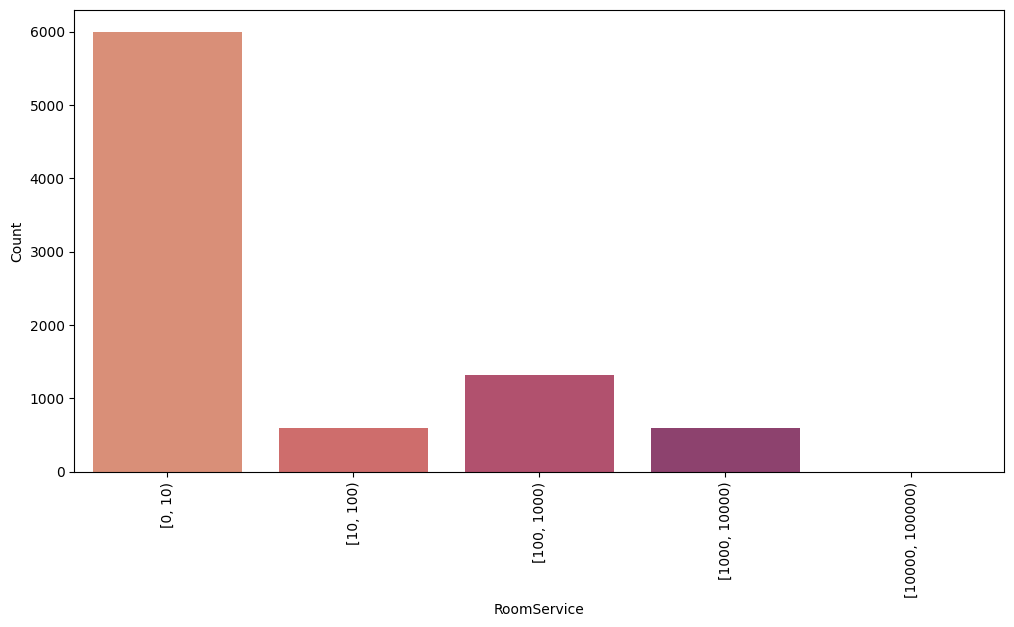

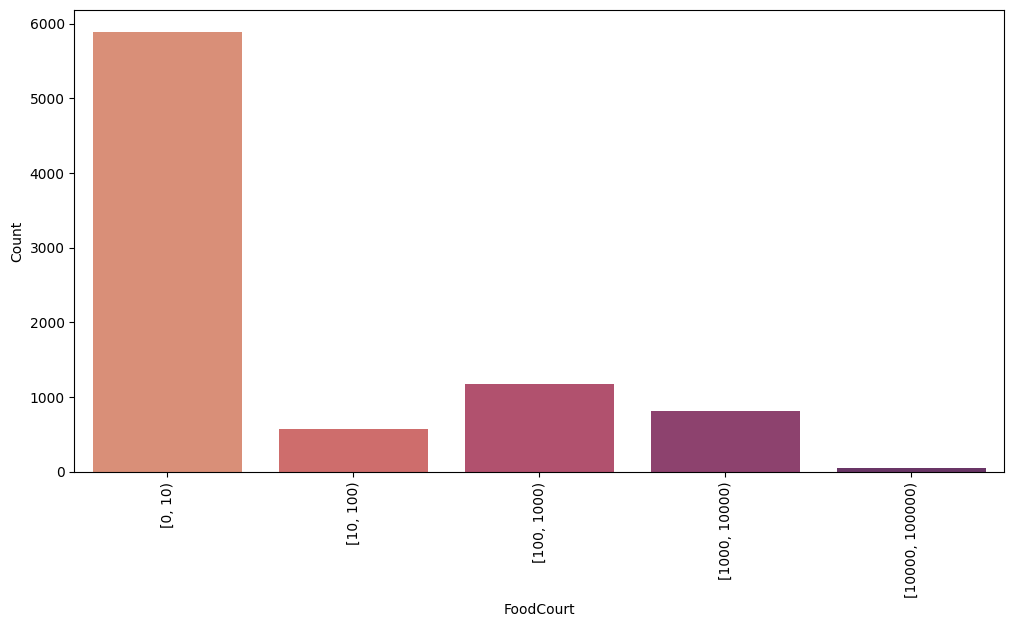

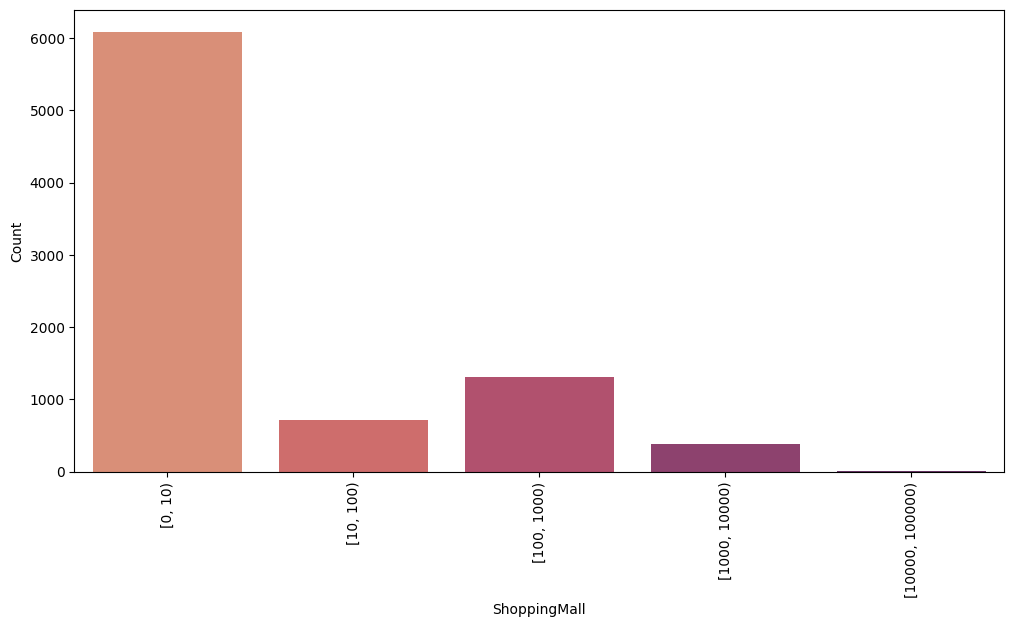

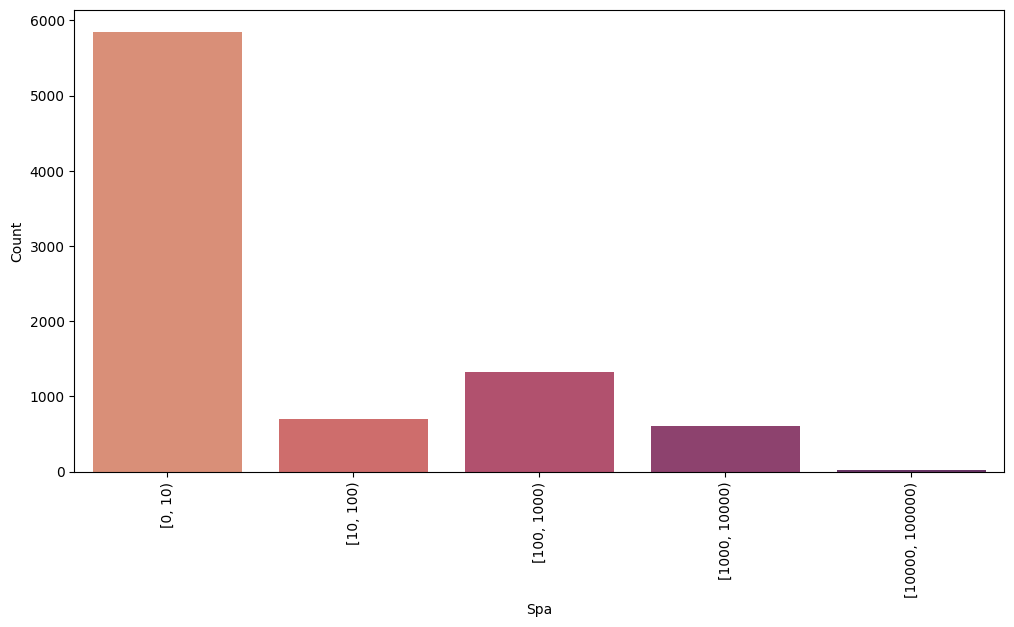

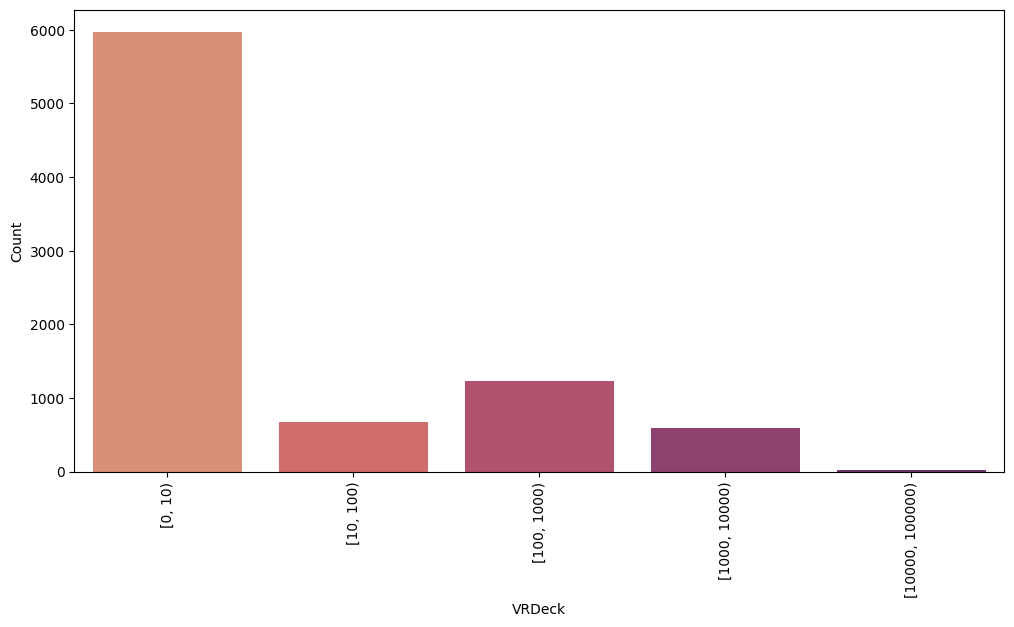

In [481]:
# Draw graphs to see the distribution of the spending categories
for category in spending_categories:
    cat_df = pd.cut(train_df[category], bins, right=False)
    df_counts = cat_df.value_counts().sort_index().reset_index(name='Count').rename(columns={'index': 'Range'})
    plt.figure(figsize=(12, 6))  # Increase the size of the plot
    ax = sns.barplot(data=df_counts, x=category, y='Count', palette='flare')
    plt.xticks(rotation=90)  # Rotate the x-axis labels
    plt.show()

<Axes: >

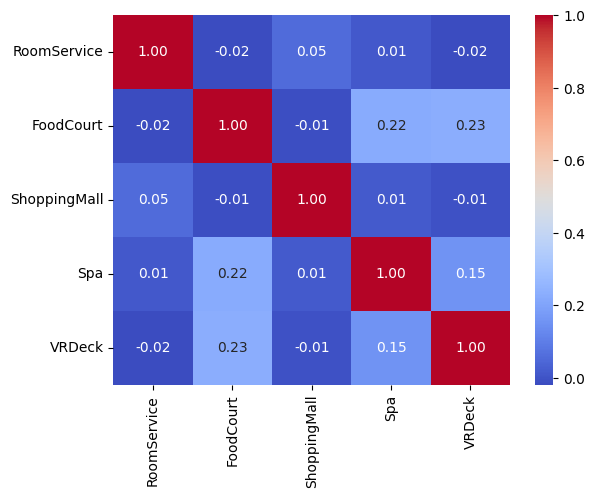

In [482]:
# Calculate the correlation between the Spending Categories
sns.heatmap(train_df[spending_categories].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

From this we can see there is a modest correlation between FoodCourt, Spa and VRDeck

Perhaps we can use the following logic

```
if FoodCourt missing
    if Spa present
        if VRDeck present
            use the highest of the two bins
        else
           use Spa bin
    else
        set to zero

```

See the `fill_in_missing_spend` function in "Apply the empty data handling"

### Age

The last continuous variable to sort out empty values for is age. For now given there is quite a strong peak around 25-30 lets fill with the median.

## Missing categorical data

The categorical data we need to fill missing values for are:

- HomePlanet      
- Name            
- Cabin           
- DeckSide        
- Destination     

We will now look at these. 

### Name

Name is an add one and given it is unlikely to be that meaningful lets just fill with 'Unknown'

### HomePlanet and Destination

Perhaps these might be more likely to be in common within a group so lets explore that idea

#### Destination

In [483]:
# Original Python code
# destination_values = train_df['Destination'].unique()
# print(f'Destination values: {destination_values}')

# Trappist= 'TRAPPIST-1e' 
# Pso = 'PSO J318.5-22' '55 Cancri e'
# Cancri = '55 Cancri e'

# single_dest_groups = 0
# dual_dest_groups_75_25_split = 0
# multi_dest_groups = 0
# no_dest_groups = 0

# for group in train_df['Group'].unique():
#     dest = train_df[train_df['Group'] == group]['Destination']
#     nan_present = dest.isnull().sum() > 0
#     uniq_dest = len(dest.unique())
#     if nan_present:
#         uniq_dest -= 1
    
#     if uniq_dest == 0:
#         no_dest_groups += 1
#     elif uniq_dest == 1:
#         single_dest_groups += 1
#     elif uniq_dest == 2:
#         dest1, dest2 = [d for d in dest.unique() if d in destination_values]
#         # get count of dest1 and dest2
#         dest1_count = (dest == dest1).sum()
#         dest2_count = (dest == dest2).sum()
#         if min(dest1_count, dest2_count)/max(dest1_count, dest2_count) >= 0.75:
#             dual_dest_groups_75_25_split += 1
#         else:
#             multi_dest_groups += 1

In [484]:
# Improved Pandas version
def determine_group_category(group, field: str):
    locn = group[field]
    nan_present = locn.isnull().sum() > 0
    uniq_locn = len(locn.unique())
    if nan_present:
        uniq_locn -= 1

    if uniq_locn == 0:
        return 'no_locn'
    elif uniq_locn == 1:
        return 'single_locn'
    elif uniq_locn == 2:
        locn1, locn2 = locn.dropna().unique()
        locn1_count = (locn == locn1).sum()
        locn2_count = (locn == locn2).sum()
        if max(locn1_count, locn2_count)/(locn1_count + locn2_count) >= 0.75:
            return 'dual_locn_75_25_split'
        else:
            return 'multi_locn'
    else:
        return 'multi_locn'

group_categories = train_df.groupby('Group').apply(determine_group_category, field='Destination') # passes the field name to the function
group_categories.value_counts()




single_locn              5397
multi_locn                635
no_locn                   103
dual_locn_75_25_split      82
Name: count, dtype: int64

So the results:

```
single_locn              5397
multi_locn                635
no_locn                   103
dual_locn_75_25_split      82
```
suggest that in the vast majority of cases (5397 + 380) the majority of the group is going to the same place

- would be reasonable to use the modal value of the group provided there are one or two destinations and at least 75% in the case of the latter are going to one of the 2 (choose that one)
- no good solution for the others so tempted to set to 'Unknown'

#### HomePlanet

In [485]:
# We can run the same analysis for HomePlanet
planet_categories = train_df.groupby('Group').apply(determine_group_category, field='HomePlanet')
planet_categories.value_counts()

single_locn    6107
no_locn         110
Name: count, dtype: int64

In [486]:
# The above result seems to perfect so cross validate it by checking the unique values in the HomePlanet column for each group
group_categories = train_df.groupby('Group')['HomePlanet'].agg(lambda x: set(x.unique()))
group_categories.value_counts()

HomePlanet
{Earth}          3574
{Europa}         1238
{Mars}           1206
{nan}             110
{nan, Earth}       31
{nan, Europa}      30
{Mars, nan}        28
Name: count, dtype: int64

Ok so here it is easier we can set to the non-nan value in the same group otherwise we will have to go with 'Unknown'

## Cabin, DeckSide, Name

For Name and Cabin Lets just fill with 'Unknown' as we will likely drop them anyway and cannot guess

In [488]:
# Lets see within a group the count of unique DeckSides
total_count_groups = train_df['Group'].nunique()
group_categories = train_df.groupby('Group')['DeckSide'].agg(lambda x: set(x.dropna().unique())).reset_index()
group_categories = group_categories[group_categories['DeckSide'].map(len) > 1]

print(f'Found that {len(group_categories)} of {total_count_groups} groups have more than one unique DeckSide')

Found that 421 of 6217 groups have more than one unique DeckSide


Most groups have a single `DeckSide` so think we will go with the mode for the group

## Apply the empty data handling

In [489]:
# This function will handle empty values in the Destination column
# The rules are that we will fill null / NaN values with the most common destination in the group
# 1. if there is only one destination that is not null then fill the empty values with that destination 
# 2. if there are two destinations and one is 75% of the filled values or more then fill the empty values with the larger destination
# 3. Otherwise fill with 'Unknown'
# def fill_destination(group):
#     dest = group['Destination']
#     dest_vals = dest.dropna().unique()
#     count_dest_vals = len(dest_vals)
#     # print(f'Group: {group.name}, Destination values: {dest_vals}')
#     if count_dest_vals == 0:
#         # print(f'Group: {group.name} has no destination values - set Unknown!')
#         return 'Unknown'
#     elif count_dest_vals == 1:
#         # print(f'Group: {group.name} has a single destination values - set {dest.mode().values[0]}')
#         return dest.mode().values[0]
#     elif count_dest_vals == 2:
#         dest1, dest2 = dest_vals
#         dest1_count = (dest == dest1).sum()
#         dest2_count = (dest == dest2).sum()
#         if max(dest1_count, dest2_count)/(dest1_count + dest2_count) >= 0.75:
#             # print(f'Group: {group.name} has a two destination values {dest1=}, {dest2=}, {dest1_count=}, {dest2_count=} - set dest.mode().values[0]')
#             return dest.mode().values[0]
#         else:
#             # print(f'Group: {group.name} has a multiple destination values - set Unknown')
#             return 'Unknown'
#     else:
#         # print(f'Group: {group.name} has many destinations - set Unknown')
#         return 'Unknown'
    
# def determine_fill_value(dest, dest_vals, count_dest_vals):
#     if count_dest_vals == 0:
#         return 'Unknown'
#     elif count_dest_vals == 1:
#         return dest.mode().values[0]
#     elif count_dest_vals == 2:
#         dest1, dest2 = dest_vals
#         dest1_count = (dest == dest1).sum()
#         dest2_count = (dest == dest2).sum()
#         if max(dest1_count, dest2_count)/(dest1_count + dest2_count) >= 0.75:
#             return dest.mode().values[0]
#         else:
#             return 'Unknown'
#     else:
#         return 'Unknown'

# def fill_destination(group):
#     dest = group['Destination']
#     dest_vals = dest.dropna().unique()
#     count_dest_vals = len(dest_vals)
#     fill_value = determine_fill_value(dest, dest_vals, count_dest_vals)
#     return fill_value

# # Apply the function to the Destination column one group at a time in pandas
# train_df['Destination'] = train_df.groupby('Group').apply(fill_destination)


def fill_in_missing_destination(df: pd.DataFrame) -> pd.DataFrame:
        
    # Calculate the mode of 'Destination' within each group if a reasonable value can be determined
    destination_modes = df.groupby('Group')['Destination'].transform(
        lambda x: 
          x.mode()[0] 
          if len(x.dropna().unique()) == 1
          or (len(x.dropna().unique()) == 2 and max(x.value_counts(normalize=True)) >= 0.75) 
          else np.nan
    )
        
    # Fill in missing 'Destination' values with the mode of the 'Destination' values in the same group
    df['Destination'].fillna(destination_modes, inplace=True)
    
    # If the mode is also NaN (i.e., all 'Destination' values in a group are missing), fill in with 'Unknown'
    df['Destination'].fillna('Unknown', inplace=True)
    
    return df

In [490]:
# This function will handle empty values in the HomePlanet column

def fill_in_missing_home(df: pd.DataFrame) -> pd.DataFrame:
    
    # Calculate the mode of 'HomePlanet' within each group
    homeplanet_modes = df.groupby('Group')['HomePlanet'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    
    # Fill in missing 'HomePlanet' values with the mode of the 'HomePlanet' values in the same group
    df['HomePlanet'].fillna(homeplanet_modes, inplace=True)
    
    # If the mode is also NaN (i.e., all 'HomePlanet' values in a group are missing), fill in with 'Unknown'
    df['HomePlanet'].fillna('Unknown', inplace=True)
    
    return df

In [491]:
# This function handles empty values in the spending columns

def extract_best_spend_value(row: pd.Series, category: str, source_categories: list) -> float:
    # If the value is not null then return it
    if pd.notnull(row[category]):
        return row[category]
    
    # If the value is null then return the max of the other categories
    other_values = [row[cat] for cat in source_categories if pd.notnull(row[cat])]
    if len(other_values) == 0:
        return 0
    return np.max(other_values)

spending_categories = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Define a function that will for a given missing value in the spending_categories will fill in the best value 
def fill_in_missing_spend(df: pd.DataFrame) -> pd.DataFrame:
    df['FoodCourt'] = df.apply(
        lambda row: extract_best_spend_value(row, 'FoodCourt', ['Spa', 'VRDeck']), 
        axis=1
    )
    
    df['Spa'] = df.apply(
        lambda row: extract_best_spend_value(row, 'Spa', ['FoodCourt', 'VRDeck']), 
        axis=1
    )
    
    df['VRDeck'] = df.apply(
        lambda row: extract_best_spend_value(row, 'VRDeck', ['FoodCourt', 'Spa']), 
        axis=1
    )
    
    df['RoomService'] = df.apply(
        lambda row: extract_best_spend_value(row, 'RoomService', []), 
        axis=1
    )
    
    df['ShoppingMall'] = df.apply(
        lambda row: extract_best_spend_value(row, 'ShoppingMall', []), 
        axis=1
    )    
    return df

In [495]:
def handle_empty_data(df: pd.DataFrame) -> pd.DataFrame:
    # for the provided dataframe set VIP to False if it is null or NaN
    df['VIP'] = df['VIP'].fillna(False)

    # for now we will use the median age to fill in the missing ages
    df['Age'] = df['Age'].fillna(df['Age'].median())

    # for the provided dataframe set CryoSleep to False if TotalSpend is greater than 0
    UnknownCryoSpender = (df["CryoSleep"].isnull() | df["CryoSleep"].isna()) & (df["TotalSpend"] > 0)
    df.loc[UnknownCryoSpender, 'CryoSleep'] = False
    df['CryoSleep'] = df['CryoSleep'].fillna('Unknown')
    
    # Fill missing values in the 'Name' and 'Cabin' columns with 'Unknown'
    df['Name'] = df['Name'].fillna('Unknown')
    df['Cabin'] = df['Cabin'].fillna('Unknown')

    df = fill_in_missing_spend(df)

    df = fill_in_missing_home(df)

    df = fill_in_missing_destination(df)

    # fill in missing values in the DeckSide column with the mode for its group
    df['DeckSide'] = df.groupby('Group')['DeckSide'].transform(
        lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna('Unknown')
        )
    
    return df

train_df_b4 = train_df.copy()
test_df_b4 = test_df.copy()

train_df = handle_empty_data(train_df)
test_df = handle_empty_data(test_df)

In [496]:
# Check the training data

train_df.isnull().sum().sort_values(ascending = False)


PassengerId     0
HomePlanet      0
GroupSize       0
Group           0
DeckSide        0
Transported     0
Name            0
VRDeck          0
Spa             0
ShoppingMall    0
FoodCourt       0
RoomService     0
VIP             0
Age             0
Destination     0
Cabin           0
CryoSleep       0
TotalSpend      0
dtype: int64

In [497]:
# Check the test data
test_df.isnull().sum().sort_values(ascending = False)

PassengerId     0
ShoppingMall    0
GroupSize       0
Group           0
DeckSide        0
Name            0
VRDeck          0
Spa             0
FoodCourt       0
HomePlanet      0
RoomService     0
VIP             0
Age             0
Destination     0
Cabin           0
CryoSleep       0
TotalSpend      0
dtype: int64

### And thats a wrap!

There are now no missing values so we can proceed to Pre-processing

# Data Preprocessing

## Quick check of the data after the empty data is filled

In [498]:
# Look at the training data after the changes to remove empty data
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,DeckSide,Group,GroupSize,TotalSpend
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Ofracculy,False,BP,0001,1,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Vines,True,FS,0002,1,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Susent,False,AS,0003,2,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Susent,False,AS,0003,2,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Santantines,True,FS,0004,1,1091.0


In [499]:
# Look at the test data
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,DeckSide,Group,GroupSize,TotalSpend
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Carsoning,GS,0013,1,0.0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Peckers,FS,0018,1,2832.0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Unhearfus,CS,0019,1,0.0
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Caltilter,CS,0021,1,7418.0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Harperez,FS,0023,1,645.0


In [502]:
# Check the shapes:

print(f'Train: {train_df.shape}')
print(f'Test: {test_df.shape}')

# Check the train and test column data types side by side
pd.concat([train_df.dtypes, test_df.dtypes], axis=1, keys=['Train', 'Test'])



Train: (8693, 18)
Test: (4277, 17)


,Train,Test
PassengerId,object,object
HomePlanet,object,object
CryoSleep,object,object
Cabin,object,object
Destination,object,object
Age,float64,float64
VIP,bool,bool
RoomService,float64,float64
FoodCourt,float64,float64
ShoppingMall,float64,float64


## Drop Unrequired columns

We can now drop these columns:

- Cabin
- TotalSpend
- PassengerId - may do this one last so we have the key

In [503]:
# Drop the columns that are not required
def drop_unrequired_columns(df: pd.DataFrame) -> pd.DataFrame:
    columns_to_drop = [
        # 'PassengerId',
        'TotalSpend', 
        'Cabin'
    ]
    df.drop(columns_to_drop, axis = 1, inplace = True)
    return df

train_df = drop_unrequired_columns(train_df)
test_df = drop_unrequired_columns(test_df)